In [1]:
#imports
import sys
sys.path.append("utils")

import os
import math
from rdkit import Chem
from alive_progress import alive_bar
from rdkit.Chem import AllChem
import numpy as np


from openmm import ReaxffForce, NonbondedForce, app, unit, Platform, LangevinIntegrator, Vec3
from openmm.app import Modeller, ForceField, PDBFile, Simulation, PDBReporter

from openff.toolkit import Molecule
from openmmforcefields.generators import GAFFTemplateGenerator


from TopologyTools import TopologyTools, calculate_bounding_box
from EMReporter import EnergyMinimizationReporter

from ReaxFFHelpers  import remove_extra_forces

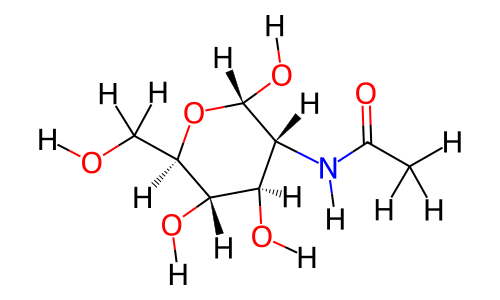

In [2]:
rdmol_base = Chem.MolFromMol2File("NDG.mol2")
molecule = Molecule.from_rdkit(rdmol_base)
molecule.generate_unique_atom_names()
molecule.visualize()

In [3]:
topology = molecule.to_topology().to_openmm()
TopologyTools.add_chain_name("REAX", topology)
molecule.to_topology().get_positions().to_openmm().mean(axis=0)

Quantity(value=array([ 0.3115758 , -0.0989096 ,  0.96876491]), unit=nanometer)

In [4]:
protein = PDBFile("7xf7-centered-protein.pdb")
protein_topology = protein.topology
TopologyTools.add_chain_name("PROTEIN", protein_topology)
protein.positions.mean()

Warning, renaming chain, old chain id was  A .


Quantity(value=Vec3(x=-0.005122018802572533, y=-0.005225927758535016, z=-0.012155863433943596), unit=nanometer)

In [5]:
min_coords, max_coords = calculate_bounding_box(protein)
print("Bounding Box:")
print(f"Min: {min_coords}")
print(f"Max: {max_coords}")
sizes = max_coords-min_coords

Bounding Box:
Min: Vec3(x=-1.9010000000000002, y=-1.7717, z=-1.8795000000000002)
Max: Vec3(x=1.7163000000000002, y=1.7773, z=2.3031)


In [6]:
modeller = Modeller(topology, molecule.to_topology().get_positions().to_openmm())

In [7]:
modeller.add(protein_topology, protein.positions)

In [8]:
#for the small molecule
gaff = GAFFTemplateGenerator(forcefield="gaff-2.11")
forcefield = ForceField("amber14/protein.ff14SB.xml", "amber14/tip3p.xml")
forcefield.registerTemplateGenerator(gaff.generator)
gaff.add_molecules([molecule])

In [9]:
modeller.addSolvent(forcefield, model="tip3p", boxSize=5*Vec3(1, 1, 1 )*unit.nanometers)

In [10]:
output_pdb_file = 'output_with_solvent.pdb'
PDBFile.writeFile(modeller.topology, modeller.positions, open(output_pdb_file, 'w'))

In [11]:
system = forcefield.createSystem(modeller.topology, 
                                 nonbondedCutoff=1.0*unit.nanometers,
                                 switchDistance=0.9*unit.nanometers,
                                 hydrogenMass=4*unit.amu,
                                 rigidWater=True,
                                 constraints=app.AllBonds,
                                 nonbondedMethod=app.CutoffNonPeriodic,
                                 removeCMMotion=True
                                )

In [12]:
reax_atoms = [atom.index for atom in modeller.topology.atoms() if atom.residue.chain.id == "REAX"]
atom_symbols = [atom.element.symbol for atom in modeller.topology.atoms()]
non_reax_atoms = [atom.index for atom in modeller.topology.atoms() if atom.index not in reax_atoms]

In [13]:
cog = (protein.positions.mean()+ 4*np.array([1,1,1])*unit.nanometer)
cog

Quantity(value=Vec3(x=3.9948779811974275, y=3.994774072241465, z=3.987844136566056), unit=nanometer)

In [14]:
cog_molecule = np.array([0.,0.,0.])*unit.nanometer
for molpos in molecule.to_topology().get_positions().to_openmm():
    cog_molecule+=molpos.mean(axis=0)
cog_molecule

Quantity(value=array([11.81431106, 11.81431106, 11.81431106]), unit=nanometer)

In [15]:
dist = np.linalg.norm((cog-cog_molecule).value_in_unit(unit.nanometer))

In [16]:
from openmm import CustomExternalForce, CustomCentroidBondForce
protein_atoms = [atom.index for atom in modeller.topology.atoms() if atom.residue.chain.id == "PROTEIN"]

In [17]:
force = CustomExternalForce('100*max(0, r-cogr)^2; r=sqrt((x-cogx)*(x-cogx)+(y-cogy)*(y-cogy)+(z-cogz)*(z-cogz))')
force.addGlobalParameter('cogr', 5.2*unit.nanometer)
force.addGlobalParameter("cogx", cog[0])
force.addGlobalParameter("cogy", cog[1])
force.addGlobalParameter("cogz", cog[2])

for i in protein_atoms:
    force.addParticle(i, [])
    
for i in reax_atoms:
    force.addParticle(i, [])
system.addForce(force)
#flat bottomned well between ligand cog and protein cog
force = CustomCentroidBondForce(2, '0.5*kres*step(distance(g1, g2) - r0)*(distance(g1, g2) - r0)^2')
force.addGlobalParameter('r0', dist)
force.addGlobalParameter('kres', 100*unit.kilojoule_per_mole/unit.nanometers**2)
force.addGroup(reax_atoms, [1.0 for el in reax_atoms])
force.addGroup(protein_atoms, [1.0 for el in protein_atoms])
force.addBond([0, 1])
system.addForce(force)

6

# ReaxFF-Specific Setup Steps
    - set charges to 0 for reaxff atoms, but not with exceptions, because it is hard on the shared memory
    - remove the classic MD forces from the reaxff atoms. 
    - remove constraints from reaxff atoms (optional, but usually necesssary)

In [18]:
force = ReaxffForce("../tests/ffield.reaxff", "../tests/control")

In [19]:
# set charges to 0 and copy MM charges for reaxff 
nonbonded_force = next(
    force for force in system.getForces() if isinstance(force, NonbondedForce)
)
for i in range(nonbonded_force.getNumParticles()):
    charge, sigma, epsilon = nonbonded_force.getParticleParameters(i)
    if i in reax_atoms:
        nonbonded_force.setParticleParameters(i, 0.0, sigma, epsilon)
        force.addAtom(i, atom_symbols[i], 0.0, True)
    else:
        force.addAtom(i, atom_symbols[i], charge, False)

In [20]:
remove_extra_forces(system, reax_atoms)

Number of bond forces before update:  0
Number of bond forces after update:  0
Number of angle forces before update:  3708
Number of angle forces after update:  3655
Number of torsion forces before update:  6888
Number of torsion forces after update:  6799


In [21]:
ncs = system.getNumConstraints()
for i in range(system.getNumConstraints() - 1, -1, -1):
    particle1, particle2, dist = system.getConstraintParameters(i)
    if (particle1 in reax_atoms) or (particle2 in reax_atoms):
        #pass
        system.removeConstraint(i)
print("Removed ", ncs-system.getNumConstraints(), " constraints.")

Removed  30  constraints.


In [22]:
print("Number of MM atoms: ", len(non_reax_atoms))
print("Number of ReaxFF atoms: ", len(reax_atoms))

Number of MM atoms:  11365
Number of ReaxFF atoms:  30


In [23]:
system.addForce(force);

In [24]:
platform = Platform.getPlatform('CUDA')

In [27]:
compound_integrator = LangevinIntegrator(300*unit.kelvin, 10/unit.picoseconds, 0.25*unit.femtoseconds)
simulation = Simulation(modeller.topology, system, compound_integrator, platform)
simulation.context.setPositions(modeller.positions)
simulation.reporters.append(PDBReporter(f'NVT_REAX.pdb', 100))

In [28]:
# if the output values are too high you there is probably some clash in the geometry
# the proper way of resolving this is to have a previous classical equilibriation run, as
# reaxff shouldnt really be used for a full minimization, becuse of the reacivity
simulation.minimizeEnergy(reporter=EnergyMinimizationReporter("min.dat"), maxIterations=10, tolerance=1E2)

0 740328.244484841
0 751413.5934412706
0 752114.0965202741
0 748494.794819831
0 748062.1670750482


In [29]:
temperature_start = 0
temperature_end = 300
temperature = temperature_start

mdsteps = 1e3
print("NVT Heatup")

with alive_bar(100, force_tty=True) as bar:
    for i in range(100):
        #heat up whole system to 300K
        compound_integrator.setTemperature(temperature*unit.kelvin)
        simulation.step(mdsteps/100)
        temperature += (temperature_end-temperature_start)/100
        bar() 
print("Done.")

NVT Heatup

Done.
██████████████████████████████████| 100/100 [100%] in 1:08.4 (1.46/s)    